<a href="https://colab.research.google.com/github/dinaabd3/teeth_calssifiction/blob/main/Copy_of_TASK033.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-

import os
import numpy as np
import matplotlib.pyplot as plt
import random

# تركيب الحزم المطلوبة (مرات تشغيل فقط)
!pip install opencv-python
!pip install tensorflow
!pip install tifffile

import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.model_selection import train_test_split
import tifffile
from PIL import Image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 18.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# تأكدي من هذا المسار حسب مكان ملفاتك على Google Drive أو جهازك
image_path = '/content/drive/MyDrive/data3/satalite data/data/images'
label_path = '/content/drive/MyDrive/data3/satalite data/data/labels'


In [ ]:
def load_multispectral_images_tif(folder_path, img_size=(128,128), bands=12):
    images = []
    files = sorted(os.listdir(folder_path))
    for f in files:
        if not f.endswith('.tif'):
            continue
        img_path = os.path.join(folder_path, f)
        try:
            img = tifffile.imread(img_path)
            if img.shape[:2] != img_size:
                channels = []
                for b in range(img.shape[2]):
                    ch = cv2.resize(img[..., b], img_size)
                    channels.append(ch)
                img = np.stack(channels, axis=-1)
            if img.shape[2] != bands:
                print(f"Warning: {f} does not have {bands} channels, it has {img.shape[2]}")
                continue
            images.append(img)
        except Exception as e:
            print(f"Failed to load {img_path} with error: {e}")
    return np.array(images)

def load_masks(folder_path, img_size=(128,128)):
    masks = []
    files = sorted(os.listdir(folder_path))
    for f in files:
        if not (f.endswith('.tif') or f.endswith('.png') or f.endswith('.jpg')):
            continue
        mask_path = os.path.join(folder_path, f)
        try:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask.shape != img_size:
                mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
            mask = (mask > 127).astype(np.uint8)  # ثنائية القيم
            masks.append(mask[..., np.newaxis])
        except Exception as e:
            print(f"Failed to load mask {mask_path} with error: {e}")
    return np.array(masks)


In [ ]:
image_dir = '/content/drive/MyDrive/data3/satalite data/data/images'
mask_dir = '/content/drive/MyDrive/data3/satalite data/data/labels'

X = load_multispectral_images_tif(image_dir)
Y = load_masks(mask_dir)

print(f"Loaded {X.shape[0]} images and {Y.shape[0]} masks")


Loaded 306 images and 456 masks


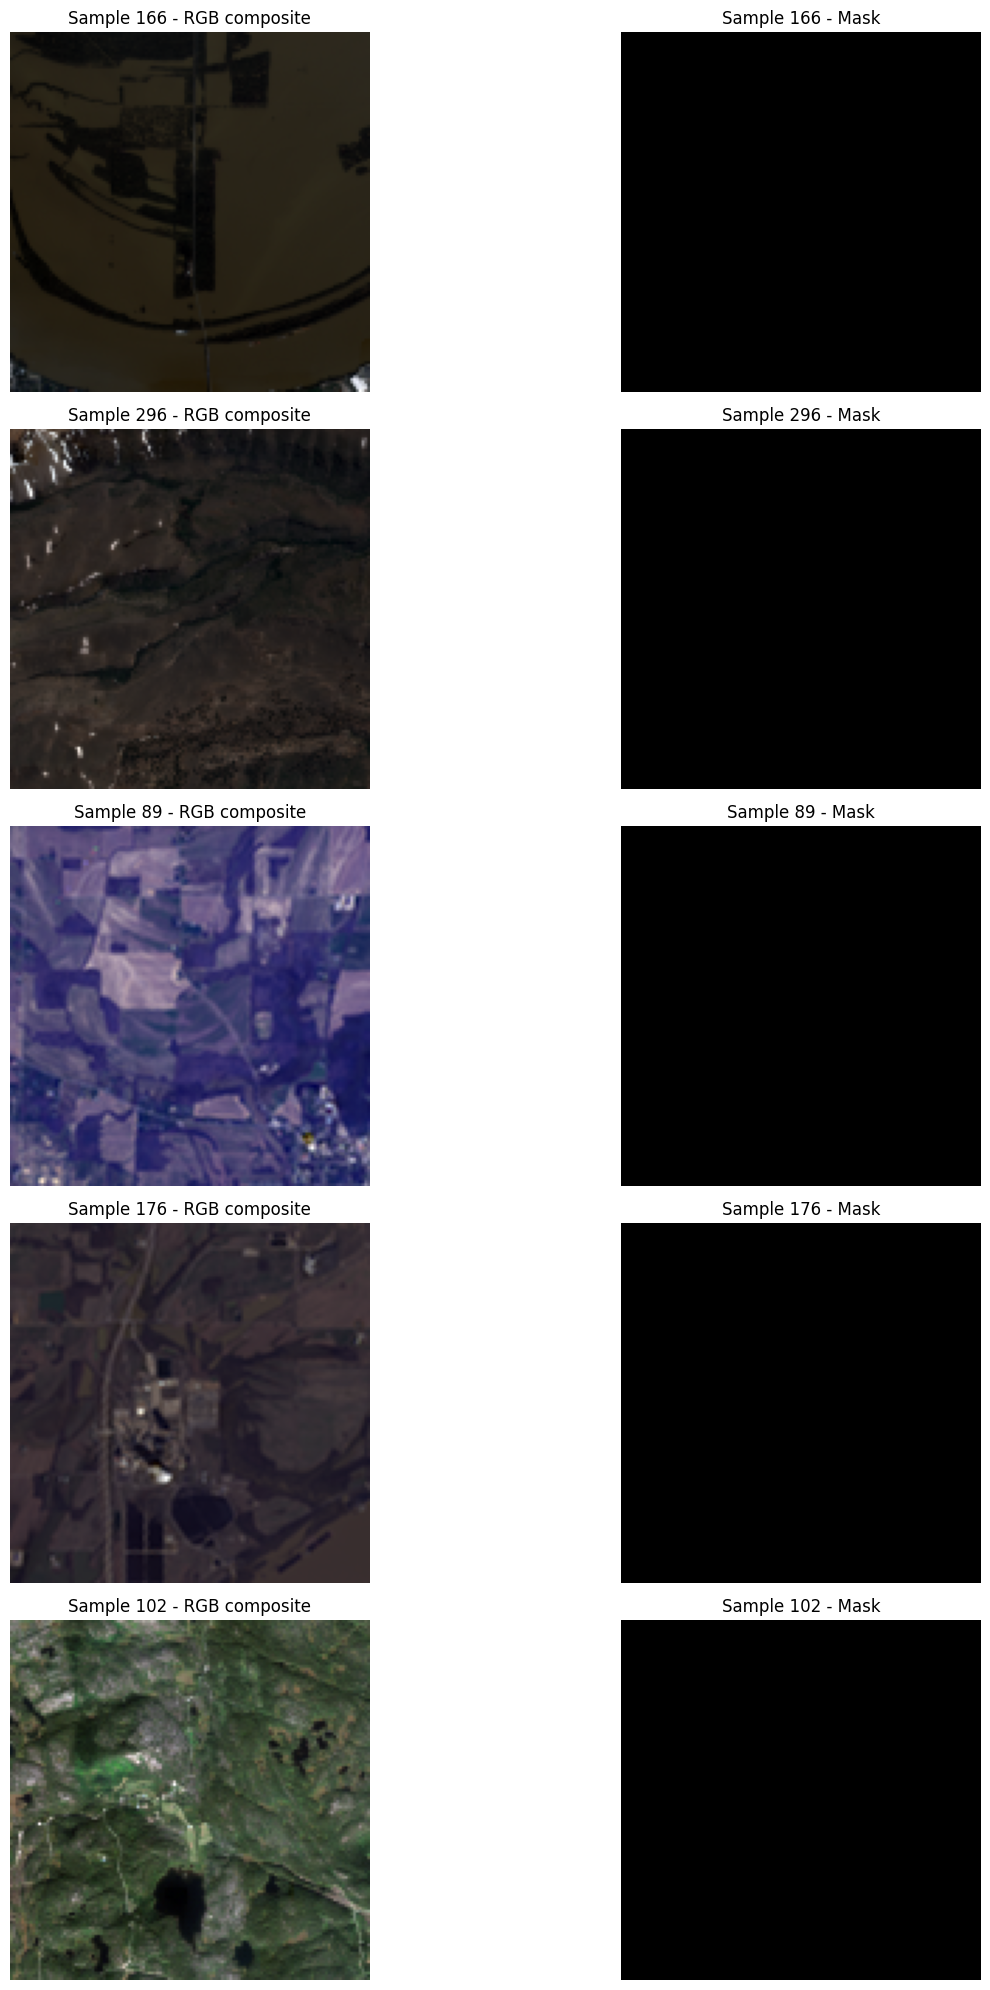

In [ ]:
def display_random_samples(X, Y, num_samples=5, bands_to_show=[3,2,1]):
    indices = random.sample(range(X.shape[0]), num_samples)
    plt.figure(figsize=(15, num_samples * 4))
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 2, 2*i + 1)
        def normalize_band(band):
            return (band - band.min()) / (band.max() - band.min() + 1e-6)
        rgb_img = np.stack([normalize_band(X[idx][..., b]) for b in bands_to_show], axis=-1)
        plt.imshow(rgb_img)
        plt.title(f'Sample {idx} - RGB composite')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        mask = Y[idx]
        if mask.ndim == 3:
            mask = mask[..., 0]
        plt.imshow(mask, cmap='gray')
        plt.title(f'Sample {idx} - Mask')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_random_samples(X, Y)


In [ ]:
data_path = '/content/drive/MyDrive/data3/satalite data/data'
images_path = os.path.join(data_path, 'images')
masks_path = os.path.join(data_path, 'labels')

# استخراج الملفات المتطابقة حسب اسم القاعدة
import re

def extract_base_name(filename):
    return re.split(r'[_\.]', filename)[0]

train_img_files = [f for f in os.listdir(images_path) if f.endswith('.tif')]
train_mask_files = [f for f in os.listdir(masks_path) if f.endswith(('.tif', '.png'))]

img_dict = {extract_base_name(f): f for f in train_img_files}
mask_dict = {extract_base_name(f): f for f in train_mask_files}

common_bases = set(img_dict.keys()).intersection(set(mask_dict.keys()))

image_mask_pairs = []
for base in common_bases:
    img_path = os.path.join(images_path, img_dict[base])
    mask_path = os.path.join(masks_path, mask_dict[base])
    image_mask_pairs.append({"image": img_path, "mask": mask_path})

# تقسيم البيانات
from sklearn.model_selection import train_test_split
train_pairs, val_pairs = train_test_split(image_mask_pairs, test_size=0.2, random_state=42)

train_img = [pair['image'] for pair in train_pairs]
train_mask = [pair['mask'] for pair in train_pairs]
val_img = [pair['image'] for pair in val_pairs]
val_mask = [pair['mask'] for pair in val_pairs]


In [ ]:
!pip install tensorflow scikit-learn

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

def augment_image_and_mask(image, mask):
    if np.random.rand() < 0.5:
        image = np.rot90(image)
        mask = np.rot90(mask)
    if np.random.rand() < 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    if np.random.rand() < 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    return image, mask

In [ ]:
!pip install tifffile
!pip install tensorflow

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
import tifffile
class MultispectralDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_filenames, batch_size=16, dim=(128,128), n_channels=12, shuffle=True):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_filenames))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        image_batch = [self.image_filenames[k] for k in batch_indexes]
        mask_batch = [self.mask_filenames[k] for k in batch_indexes]
        return self.__data_generation(image_batch, mask_batch)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_batch, mask_batch):
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.dim, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(image_batch, mask_batch)):
            img = tifffile.imread(img_path)
            if img.shape[:2] != self.dim:
                channels = []
                for b in range(img.shape[2]):
                    ch = cv2.resize(img[..., b], self.dim)
                    channels.append(ch)
                img = np.stack(channels, axis=-1)

            mask = None
            if mask_path.endswith('.tif'):
                mask = tifffile.imread(mask_path)
            else:
                mask = np.array(Image.open(mask_path))
            if mask.shape != self.dim:
                mask = cv2.resize(mask, self.dim, interpolation=cv2.INTER_NEAREST)
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=-1)
            mask = (mask > 127).astype(np.float32)

            img = img.astype(np.float32) / 65535.0

            # Augmentation فقط أثناء التدريب
            if self.shuffle:
                img, mask = augment_image_and_mask(img, mask)

            X[i] = img
            y[i] = mask

        return X, y

In [ ]:
def build_unet(input_shape=(128, 128, 12)):
    inputs = layers.Input(shape=input_shape)

    c1 = layers.Conv2D(16, 3, padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Dropout(0.2)(c1)
    c1 = layers.Conv2D(16, 3, padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Dropout(0.2)(c2)
    c2 = layers.Conv2D(32, 3, padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Dropout(0.3)(c3)
    c3 = layers.Conv2D(64, 3, padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    p3 = layers.MaxPooling2D()(c3)

    b = layers.Conv2D(128, 3, padding='same')(p3)
    b = layers.BatchNormalization()(b)
    b = layers.Activation('relu')(b)
    b = layers.Dropout(0.3)(b)
    b = layers.Conv2D(128, 3, padding='same')(b)
    b = layers.BatchNormalization()(b)
    b = layers.Activation('relu')(b)

    u3 = layers.UpSampling2D()(b)
    u3 = layers.concatenate([u3, c3])
    c4 = layers.Conv2D(64, 3, padding='same')(u3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv2D(64, 3, padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.concatenate([u2, c2])
    c5 = layers.Conv2D(32, 3, padding='same')(u2)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Conv2D(32, 3, padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)

    u1 = layers.UpSampling2D()(c5)
    u1 = layers.concatenate([u1, c1])
    c6 = layers.Conv2D(16, 3, padding='same')(u1)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Conv2D(16, 3, padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c6)

    model = models.Model(inputs, outputs)
    return model


In [ ]:
image_dir = '/content/drive/MyDrive/data3/satalite data/data/images'
mask_dir = '/content/drive/MyDrive/data3/satalite data/data/labels'
import os
import re

def extract_base_name(filename):
    return re.split(r'[_\.]', filename)[0]

# قائمة الصور والاقنعة
image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
mask_filenames = [f for f in os.listdir(mask_dir) if f.endswith(('.tif', '.png', '.jpg'))]

# إنشاء قاموس من الاسم الأساسي للملف (بدون امتداد) لكل ملف صورة وقناع
img_dict = {extract_base_name(f): f for f in image_filenames}
mask_dict = {extract_base_name(f): f for f in mask_filenames}

# ابحث عن الأسماء المشتركة بين الصور والاقنعة
common_bases = set(img_dict.keys()).intersection(set(mask_dict.keys()))

print(f"Total images: {len(image_filenames)}")
print(f"Total masks: {len(mask_filenames)}")
print(f"Matched pairs: {len(common_bases)}")

# فقط الملفات التي تحتوي على قناع مطابق
image_paths = [os.path.join(image_dir, img_dict[base]) for base in common_bases]
mask_paths = [os.path.join(mask_dir, mask_dict[base]) for base in common_bases]

# الآن قسم البيانات
from sklearn.model_selection import train_test_split
train_img, val_img, train_mask, val_mask = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

print(f"Train samples: {len(train_img)}")
print(f"Validation samples: {len(val_img)}")


Total images: 306
Total masks: 456
Matched pairs: 306
Train samples: 244
Validation samples: 62


In [ ]:
train_generator = MultispectralDataGenerator(
    train_img, train_mask,
    batch_size=16,
    dim=(128,128),
    n_channels=12,
    shuffle=True  # augmentation فعّال في التدريب فقط
)

val_generator = MultispectralDataGenerator(
    val_img, val_mask,
    batch_size=16,
    dim=(128,128),
    n_channels=12,
    shuffle=False
)

In [ ]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl


In [ ]:
from tensorflow.keras.optimizers import Adam

unet_model.compile(optimizer=Adam(learning_rate=1e-4), loss=combined_loss, metrics=[dice_coef])

# إعداد Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-3)

# تدريب النموذج (تعديل train_generator و val_generator حسب بياناتك)
history = unet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - dice_coef: 7.5192e-06 - loss: 1.7588 - val_dice_coef: 7.7877e-06 - val_loss: 1.6730 - learning_rate: 1.0000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - dice_coef: 7.9455e-06 - loss: 1.6845 - val_dice_coef: 8.1179e-06 - val_loss: 1.6348 - learning_rate: 1.0000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - dice_coef: 8.4979e-06 - loss: 1.6167 - val_dice_coef: 8.4962e-06 - val_loss: 1.5961 - learning_rate: 1.0000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - dice_coef: 8.9862e-06 - loss: 1.5695 - val_dice_coef: 9.0042e-06 - val_loss: 1.5513 - learning_rate: 1.0000e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - dice_coef: 9.4248e-06 - loss: 1.5317 - val_dice_coef: 9.3072e-06 - val_loss: 1.5277 - learning_rate: 1.0000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - dice_coef: 9.9056e-06 - loss: 1.4979 - val_dice_coef: 9.6485e-06 - val_loss: 1.5035 - learning_rate: 1.0000e-04
Epoch 7/50
15/15